# Priprava podatkov

In [6]:
import pandas
import pyreadstat

In [7]:
df, meta = pyreadstat.read_sav("CY08MSP_STU_QQQ.sav")

df.head()

,CNT,CNTRYID,CNTSCHID,CNTSTUID,CYC,NatCen,STRATUM,SUBNATIO,REGION,OECD,...,PV3MPRE,PV4MPRE,PV5MPRE,PV6MPRE,PV7MPRE,PV8MPRE,PV9MPRE,PV10MPRE,SENWT,VER_DAT
0,ALB,8.0,800282.0,800001.0,08MS,000800,ALB03,0080000,800.0,0.0,...,226.250,203.029,219.817,331.017,223.752,305.671,230.156,289.436,0.55561,03MAY23:10:11:25
1,ALB,8.0,800115.0,800002.0,08MS,000800,ALB03,0080000,800.0,0.0,...,298.644,321.405,320.452,284.836,364.565,304.044,347.626,352.269,0.76431,03MAY23:10:11:25
2,ALB,8.0,800242.0,800003.0,08MS,000800,ALB01,0080000,800.0,0.0,...,383.340,376.019,285.901,289.896,338.469,316.296,324.361,343.351,1.37877,03MAY23:10:11:25
3,ALB,8.0,800245.0,800005.0,08MS,000800,ALB08,0080000,800.0,0.0,...,264.532,303.422,327.793,165.575,246.156,238.322,275.860,227.466,1.49361,03MAY23:10:11:26
4,ALB,8.0,800285.0,800006.0,08MS,000800,ALB03,0080000,800.0,0.0,...,399.300,514.739,539.850,461.793,514.465,510.462,490.537,503.793,0.65249,03MAY23:10:11:26


In [8]:
# Drop rows with missing values in all relevant columns
columns_to_check = ['ST297Q01JA', 'ST297Q03JA', 'ST297Q05JA', 
                    'ST297Q06JA', 'ST297Q07JA', 'ST297Q09JA',
                    'ST004D01T', 'ST001D01T'] + [f'PV{i}MATH' for i in range(1, 11)]
df.dropna(subset=columns_to_check, inplace=True)


# Define column renaming map
column_rename_map = {
    'ST297Q01JA': 'one-on-one',
    'ST297Q03JA': 'ICT',
    'ST297Q05JA': 'video',
    'ST297Q06JA': 'small_group',
    'ST297Q07JA': 'large_group',
    'ST297Q09JA': 'none',
    'ST004D01T': 'gender',     # 1 = boy, 2 = girl
    'ST001D01T': 'grade level'    # 7-11 = grade level
}

# Select the relevant columns
math_pv_cols = [f'PV{i}MATH' for i in range(1, 11)]
final_cols = list(column_rename_map.keys()) + math_pv_cols

# Subset and rename
df = df[final_cols].rename(columns=column_rename_map)

In [9]:
import statsmodels.api as sm

predictors = ['one-on-one', 'ICT', 'video', 'small_group', 'large_group', 'none', 'gender', 'grade level']

results = []
for i in range(1, 11):
    y = df[f'PV{i}MATH']
    X = df[predictors]
    X = sm.add_constant(X)  # adds intercept
    model = sm.OLS(y, X).fit()
    results.append(model)

# Example: view summary of first plausible value
print(results[0].summary())

# Optionally: average coefficients across all PVs (not accounting for imputation variance)
import pandas as pd
coef_df = pd.DataFrame([r.params for r in results])
mean_coefs = coef_df.mean()
print("Average Coefficients Across PVs:")
print(mean_coefs)

                            OLS Regression Results                            
Dep. Variable:                PV1MATH   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     3523.
Date:                Tue, 15 Jul 2025   Prob (F-statistic):               0.00
Time:                        09:45:02   Log-Likelihood:            -3.4994e+06
No. Observations:              581012   AIC:                         6.999e+06
Df Residuals:                  581003   BIC:                         6.999e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         428.6046      0.457    937.244      

In [10]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

predictors = ['one-on-one', 'ICT', 'video', 'small_group', 'large_group', 'none', 'gender', 'grade level']
coef_list = []
se_list = []

for i in range(1, 11):
    y = df[f'PV{i}MATH']
    X = df[predictors]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    coef_list.append(model.params)
    se_list.append(model.bse)


In [11]:
coefs_df = pd.DataFrame(coef_list)
ses_df = pd.DataFrame(se_list)

# Rubin's Rules
mean_coef = coefs_df.mean()
within_var = ses_df.pow(2).mean()
between_var = coefs_df.var(ddof=1)
total_var = within_var + (1 + 1/10) * between_var  # 10 imputations
pooled_se = np.sqrt(total_var)

# 95% Confidence Intervals
ci_lower = mean_coef - 1.96 * pooled_se
ci_upper = mean_coef + 1.96 * pooled_se

# Create summary DataFrame
summary_df = pd.DataFrame({
    'coef': mean_coef,
    'se': pooled_se,
    'CI_lower': ci_lower,
    'CI_upper': ci_upper
})
print(summary_df)


                   coef        se    CI_lower    CI_upper
const        428.385861  0.501086  427.403732  429.367990
one-on-one   -20.807276  0.359554  -21.512001  -20.102550
ICT           -8.268713  0.386060   -9.025390   -7.512036
video          3.333040  0.386466    2.575567    4.090514
small_group   -0.414162  0.369530   -1.138441    0.310117
large_group  -28.787080  0.430587  -29.631031  -27.943130
none          22.602292  0.307311   21.999962   23.204621
gender         7.235065  0.294280    6.658277    7.811854
grade level    0.270580  0.009567    0.251829    0.289332


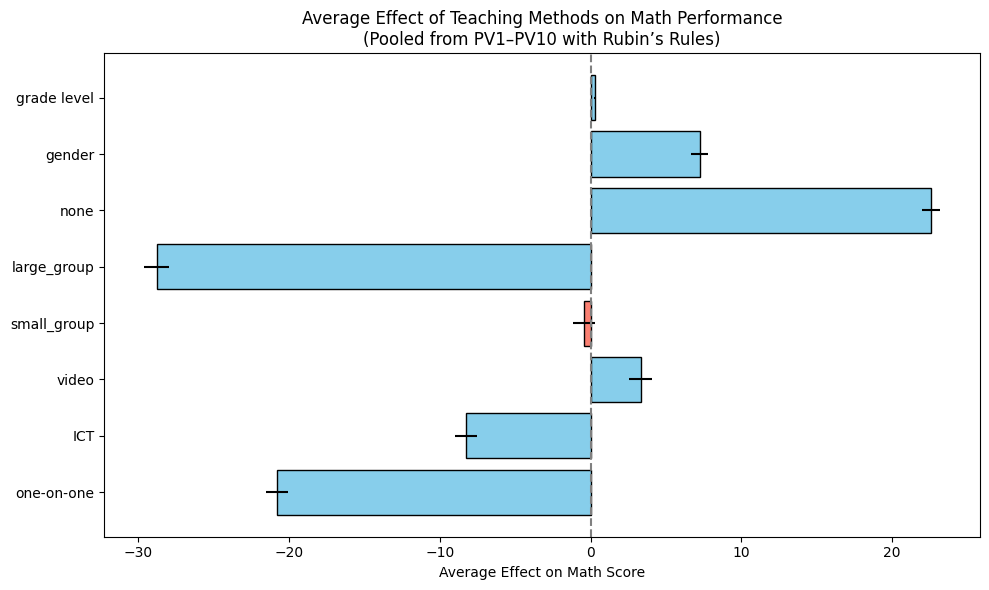

In [12]:
import matplotlib.pyplot as plt

# Drop the constant for plotting
plot_df = summary_df.drop('const').copy()

# Determine significance: True if CI does not include 0
plot_df['significant'] = ~((plot_df['CI_lower'] <= 0) & (plot_df['CI_upper'] >= 0))

# Assign bar colors: blue if significant, red if not
colors = ['skyblue' if sig else 'salmon' for sig in plot_df['significant']]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(plot_df.index, plot_df['coef'], xerr=1.96 * plot_df['se'],
         color=colors, edgecolor='black')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel('Average Effect on Math Score')
plt.title('Average Effect of Teaching Methods on Math Performance\n(Pooled from PV1–PV10 with Rubin’s Rules)')
plt.tight_layout()
plt.show()
